In [1]:
from fractions import Fraction
from itertools import product
from qiskit_nature.second_q.properties import LatticeDrawStyle
from qiskit_nature.second_q.properties.lattices import Lattice, HyperCubicLattice
from qiskit_nature.second_q.hamiltonians.basic_operators import FermionicSpinor
from qiskit_nature.second_q.operators import FermionicOp, SpinOp,MixedOp
from qiskit_nature.second_q.mappers import QubitConverter, JordanWignerMapper, LogarithmicMapper, FermionicMapper

from qiskit_nature.second_q.hamiltonians.wilson_sun_hamiltonian import WilsonModel
import matplotlib.pyplot as plt
import numpy as np
import time

from qiskit_nature.second_q.properties.lattices import BoundaryCondition
from qiskit.algorithms import NumPyEigensolver
from qiskit.opflow import Zero
numpy_solver = NumPyEigensolver()

In [2]:
import json
from qiskit.opflow import PauliSumOp
from qiskit.quantum_info import SparsePauliOp
# reading the data from the file
def read_hamiltonian(name:str):
    with open(f'/home/msd/Documents/{name}.txt') as f:
        data = f.read()
        
    # reconstructing the data as a dictionary
    js = json.loads(data)

    all_pauli_ops = None
    for el in js['paulis']:
        pauOp = SparsePauliOp(el['label'][::-1]
        ,el['coeff']['real']+1.0j*el['coeff']['imag'])
        if all_pauli_ops is None:
            all_pauli_ops=pauOp
        else:
            all_pauli_ops+=pauOp
    return PauliSumOp(all_pauli_ops)

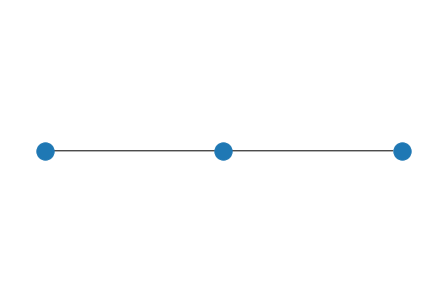

In [3]:
some_lattice = HyperCubicLattice((3,),self_loops=False,boundary_condition=BoundaryCondition.OPEN)

some_lattice.draw()


sigmax = np.array([[0.+0.j, 1.+0.j],
                   [1.+0.j, 0.+0.j]])

sigmay = np.array([[0.+0.j, 0.-1.j],
                   [0.+1.j, 0.+0.j]])

sigmaz = np.array([[1.+0.j,  0.+0.j],
                   [0.+0.j, -1.+0.j]])

dirac = [ sigmaz,sigmax*1j,sigmay*1j]

w_model = WilsonModel(  lattice = some_lattice,
                        a=1,
                        r=1.0,
                        mass=1,
                        q=1.0,#this is +-e charge or coupling
                        representation=dirac,#dirac_basis
                        flavours=1,
                        spin=1,
                        electric_field=(0,0,0),
                        e_value = 1,
                        lmbda = 0.0
)
qubit_converter = QubitConverter(mappers = [JordanWignerMapper(),LogarithmicMapper()])

# hopping,mass,link_plaquette,gauge_regulator = w_model.mock_qubit_parts()
hamiltonian = qubit_converter.convert(w_model.second_q_ops())
hopping = qubit_converter.convert(w_model.hopping_term())
mass = qubit_converter.convert(MixedOp(([w_model.mass_term(),w_model._QLM_spin.idnty()],1.0)))
link_plaquette = qubit_converter.convert(MixedOp(([w_model._fermionic_spinor.idnty(),w_model.link_term()],1.0)))
np.testing.assert_allclose((hamiltonian - sum([hopping,mass,link_plaquette])).to_matrix(),0,atol=1e-8)

Here we get the ground state energy for our hamiltonian. It is getting the right result without the gauge constraint, but not otherwise.

In [4]:
print(numpy_solver.compute_eigenvalues(hamiltonian).eigenvalues)

[-6.2219334+1.74812356e-16j]


Now we can test the mass term. As we see here there is an extra phase that I don't know where it's comming from. But other than that it is looking okay.

In [5]:
print(numpy_solver.compute_eigenvalues(mass).eigenvalues)
old_mass = read_hamiltonian('Qdiagonal_term')
print(numpy_solver.compute_eigenvalues(old_mass).eigenvalues)
print(old_mass.is_hermitian())
#check hermitian
assert (mass - 1.0j * old_mass).is_zero(), 'Not the same hamiltonian'
#The mass term has an extra phase that I don't know where is coming from.

[-6.+0.j]
[0.-6.j]
False


In [6]:
# print(numpy_solver.compute_eigenvalues(hopping).eigenvalues)
old_hopping = read_hamiltonian('Qhopp_term')
(old_hopping.to_spmatrix())
# print(numpy_solver.compute_eigenvalues(old_hopping).eigenvalues)
# print(hopping.reduce())
# print(old_hopping.reduce())
print('#######################')
print((hopping - old_hopping).reduce())

[-2.+1.32045993e-16j]
[-2.]
#######################
0.08838834764831843 * IIIXZYIIII
- 0.08838834764831843 * IIIXZYIIIZ
- 0.08838834764831843 * IIIXZYIIZI
+ 0.08838834764831843 * IIIXZYIIZZ
+ 0.06250000000000001 * IIIXZYIIIY
+ 0.06250000000000001 * IIIXZYIIZY
+ 0.08838834764831843 * IIIYZYIIII
+ 0.06250000000000001 * IIIYZYIIIX
- 0.08838834764831843 * IIIYZYIIIZ
+ 0.125 * IIIYZYIIXX
+ (0.125-3.678582752216473e-16j) * IIIYZYIIYY
- 0.08838834764831843 * IIIYZYIIZI
+ 0.06250000000000001 * IIIYZYIIZX
+ 0.08838834764831843 * IIIYZYIIZZ
+ 0.08838834764831843 * IIIXZXIIII
+ 0.06250000000000001 * IIIXZXIIIX
- 0.08838834764831843 * IIIXZXIIIZ
+ 0.125 * IIIXZXIIXX
+ 0.125 * IIIXZXIIYY
- 0.08838834764831843 * IIIXZXIIZI
+ 0.06250000000000001 * IIIXZXIIZX
+ 0.08838834764831843 * IIIXZXIIZZ
- 0.08838834764831843 * IIIYZXIIII
+ 0.08838834764831843 * IIIYZXIIIZ
+ 0.08838834764831843 * IIIYZXIIZI
- 0.08838834764831843 * IIIYZXIIZZ
- 0.06250000000000001 * IIIYZXIIIY
- 0.06250000000000001 * IIIYZXIIZY
-

In [7]:
print(numpy_solver.compute_eigenvalues(link_plaquette).eigenvalues)
old_link_plaquette = read_hamiltonian('Qgauge_part')
print(numpy_solver.compute_eigenvalues(old_link_plaquette).eigenvalues)
assert (link_plaquette-link_plaquette).is_zero(), "The operators are not the same"

[0.+0.j]
[0.+0.j]


In [8]:
print(numpy_solver.compute_eigenvalues(gauge_regulator).eigenvalues)
old_regulator = read_hamiltonian('Qgauge_regularization')
print(numpy_solver.compute_eigenvalues(gauge_regulator).eigenvalues)
print(gauge_regulator - old_regulator).reduce()

NameError: name 'gauge_regulator' is not defined

In [12]:
w_model._QLM_spin.operatorU(1)

SpinOp([('X_1', (0.7071067811865476+0j)), ('Y_1', 0.7071067811865476j)], spin=1, register_length=2)